In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.rcParams['figure.dpi'] = 200

from matplotlib import pyplot as plt
from tqdm.auto import tqdm as pbar

from ihrem.timeslice import Win, ms
from ihrem import paths
from ihrem.analysis import sne
from ihrem import trains
from ihrem.figs_comp import fig1

from IPython.display import display

import warnings
import logging
pd.set_option('mode.chained_assignment','raise')
logging.basicConfig(level=logging.INFO)
warnings.simplefilter(action='error', category=FutureWarning)


reg = paths.Registry.read_excel(paths.get_root() / 'registry_merged.xlsx')
exp_events = reg.get_all_events()
print(f'Found {len(reg.experiment_names)} experiments')

Found 57 experiments


# Single Experiment

In [3]:
exp_name = 'GL1003_20201031'
ref_channel = 1 # ch64 is in CLA

loader = reg.get_loader(exp_name).sel_channels([31, 63])

valid_win = Win(ms(hours=2), ms(hours=11))

all_beta = reg.load_all_beta(exp_name, 'beta').T.reset_index(drop=True).T
all_beta = all_beta / all_beta.quantile(.99)

raw_all_sns = sne.SharpNegativeEvents(reg.load_all_sne(exp_name, suffix='_cdf'))
raw_all_sns = raw_all_sns.patch_simplified_channels()


raw_sns = raw_all_sns.sel_between(ref_time=valid_win)
raw_sns = raw_sns.add_details(all_beta)

clean_sns = raw_sns.sel_mask(raw_sns['null_cdf'] < .05)

sns = clean_sns.sel(channel=ref_channel)

In [4]:
iei = sns.get_inter_event_intervals().dropna()
print('IEI stats:')
print(iei.describe().round(decimals=1))

IEI stats:
count    190577.0
mean        170.0
std         456.2
min           0.6
25%          39.8
50%          60.2
75%         110.5
max       11007.7
dtype: float64


## Beta vs SN rate (Fig. 1 d)

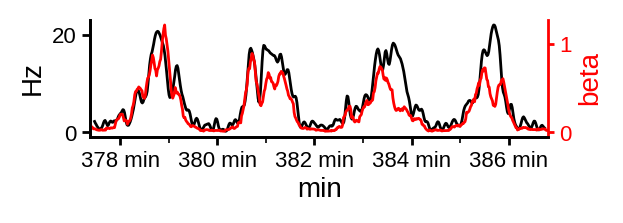

In [5]:
f = fig1.plot_beta_vs_rate(
    sns, 
    beta=all_beta[ref_channel],
    example_win=Win.build_centered(
        ms(hours=(6.2897 + 6.44720) * .5),
        ms(seconds=567),
    )
)


f.savefig(f'figs/{exp_name}_beta_vs_sn_rate.pdf')

## SN props (Fig. 1 c)

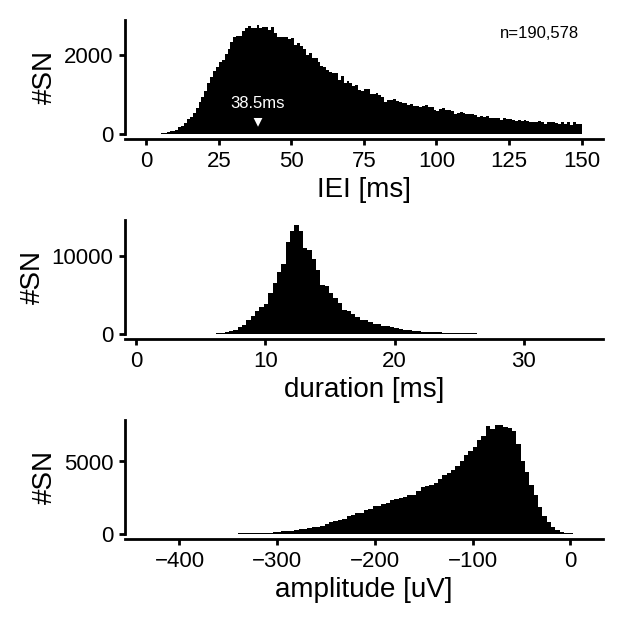

In [6]:
fig1.plot_sn_props(sns).savefig(f'figs/{exp_name}_sn_stats.pdf')

## SN average shape (Fig. 1 b)

419


load trace:   0%|          | 0/100 [00:00<?, ?it/s]

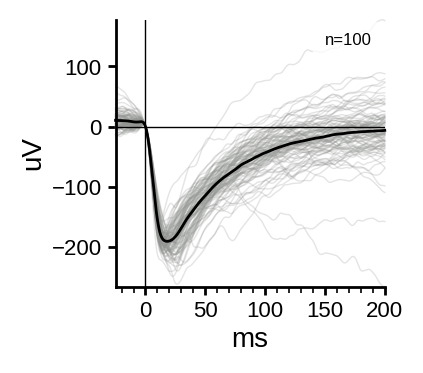

In [7]:
candidates = sns.add_isi().sel_between(amplitude=(-205, -195), isi_prev=(200, np.inf), isi_next=(200, np.inf))
print(len(candidates))
picked = candidates.sample(100, replace=False)


s = fig1.take_stack(
    loader,
    ref_channel,
    picked,
    baseline=(0, 0)
)

f = fig1.plot_example_traces(
    s.sel_between(time=(-25, 200))
)


f.savefig('figs/isolated_sn.pdf')

# Multiple experiments

In [8]:
exp_chs = [
    (0, 'GL1018_20210811'),
    (0, 'GL1018_20210812'),
    (0, 'GL1018_20210813'),
    
    (1, 'GL1003_20201031'),
    (1, 'GL1003_20201101'),
    (1, 'GL1003_20201102'),

    (0, 'GL903_20200716'),
    (0, 'GL903_20200718'),
    (0, 'GL903_20200720'),
]


exp_raw_sns, exp_beta = fig1.load_sns_multiexp(
    reg,
    exp_chs,
    valid_win=Win(ms(hours=2), ms(hours=11))
)

exp_sns = {
    exp_name: raw_sns.sel_between(null_cdf=(-np.inf, .05))
    for exp_name, raw_sns in pbar(exp_raw_sns.items())
}

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:


all_hists = {
    'iei': fig1.get_hists_iei(exp_sns, bins=np.arange(-2.5, 150 + 5, 5)),
    'dur': fig1.get_hists_prop(exp_sns, 'duration', bins=np.arange(0, 40, .5)),
    'amp': fig1.get_hists_prop(exp_sns, 'amplitude', bins=fig1.get_amp_bins(exp_sns, prop='amplitude')),
}

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
for exp_name, sns in exp_sns.items():
    print(f'{exp_name} n={len(sns):,g}')

GL1018_20210811 ch0 n=216,676
GL1018_20210812 ch0 n=220,843
GL1018_20210813 ch0 n=219,509
GL1003_20201031 ch1 n=190,578
GL1003_20201101 ch1 n=198,205
GL1003_20201102 ch1 n=198,081
GL903_20200716 ch0 n=178,170
GL903_20200718 ch0 n=208,469
GL903_20200720 ch0 n=198,541


## SN props (EDF1 a)

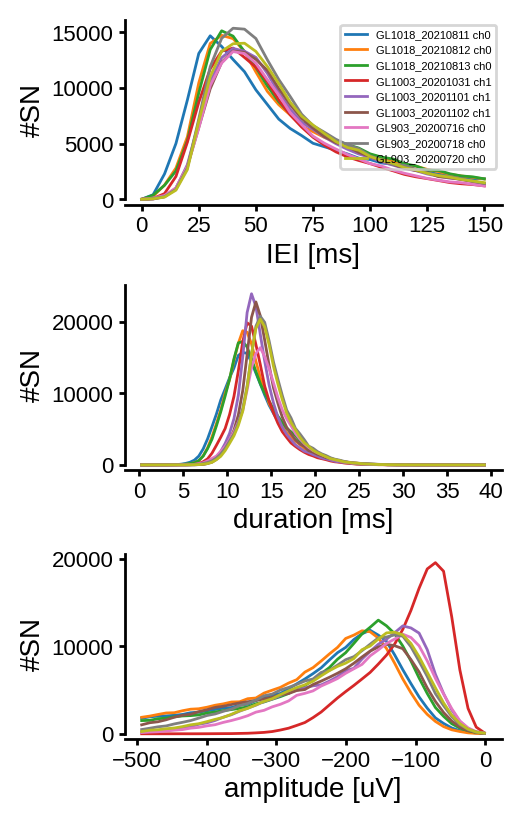

In [11]:
f, axs = plt.subplots(constrained_layout=True, nrows=3, figsize=(2.5, 4), ncols=1, sharex='row', sharey='row')

fig1.plot_hists_multiexp(axs[0], all_hists['iei'], xlabel='IEI [ms]', xticks=np.arange(0, all_hists['iei'].index.max().mid + 1, 25))

fig1.plot_hists_multiexp(axs[1], all_hists['dur'], xlabel='duration [ms]', xticks=np.arange(0, all_hists['dur'].index.max().mid + 1, 5), legend_loc=None)

fig1.plot_hists_multiexp(axs[2], all_hists['amp'], xlabel='amplitude [uV]', xticks=np.arange(-500, 1, 100), legend_loc=None)

f.savefig(f'figs/summary_sn_properties.pdf')

## Beta vs SN rate (EDF1 b)

In [12]:
exp_rates = fig1.collect_rates(exp_sns, valid_win, exp_beta)

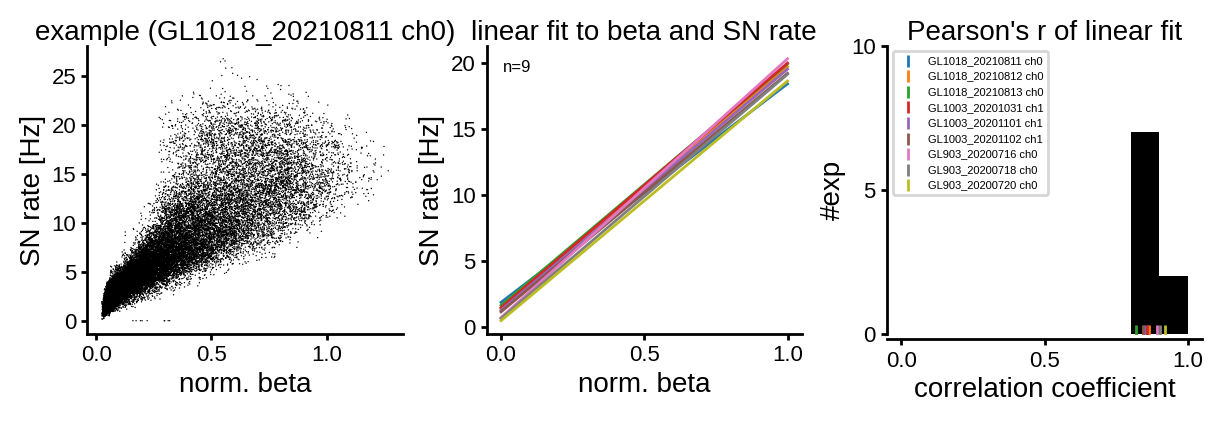

In [13]:
axs = fig1.plot_beta_vs_sn_corr(exp_rates)
axs.ravel()[0].figure.savefig(f'figs/summary_beta_vs_sn_{len(exp_rates):g}.pdf')

# SN vs Spikes (Fig. 1 e)

In [14]:
exp_name = 'GL903_20200716'
loader = reg.get_loader(exp_name)

spikes = fig1.load_example_spikes(reg, exp_name)
valid_sns = fig1.load_example_sns(reg, exp_name)

spks = spikes.sel_isin(gid=[6, 7, 8, 9])
ch_sns = valid_sns.sel(channel=1).sel_between(ref_time=valid_win)


classified_spikes = fig1.get_spikes_within_sn(ch_sns, spks)
counts = fig1.get_spike_count_per_sn(classified_spikes, ch_sns)

fig1.report_probs(counts)

prob no spike (%):
6    85.359528
7    56.123301
8    83.524128
9    82.077272
Name: 0, dtype: float64
prob >= 1 spike (%):
6    14.640472
7    43.876699
8    16.475872
9    17.922728
dtype: float64
prob > 1 spike (%):
6    0.365689
7    3.278281
8    1.481636
9    1.472693
dtype: float64


  0%|          | 0/1 [00:00<?, ?it/s]

load trace:   0%|          | 0/100 [00:00<?, ?it/s]

load trace:   0%|          | 0/100 [00:00<?, ?it/s]

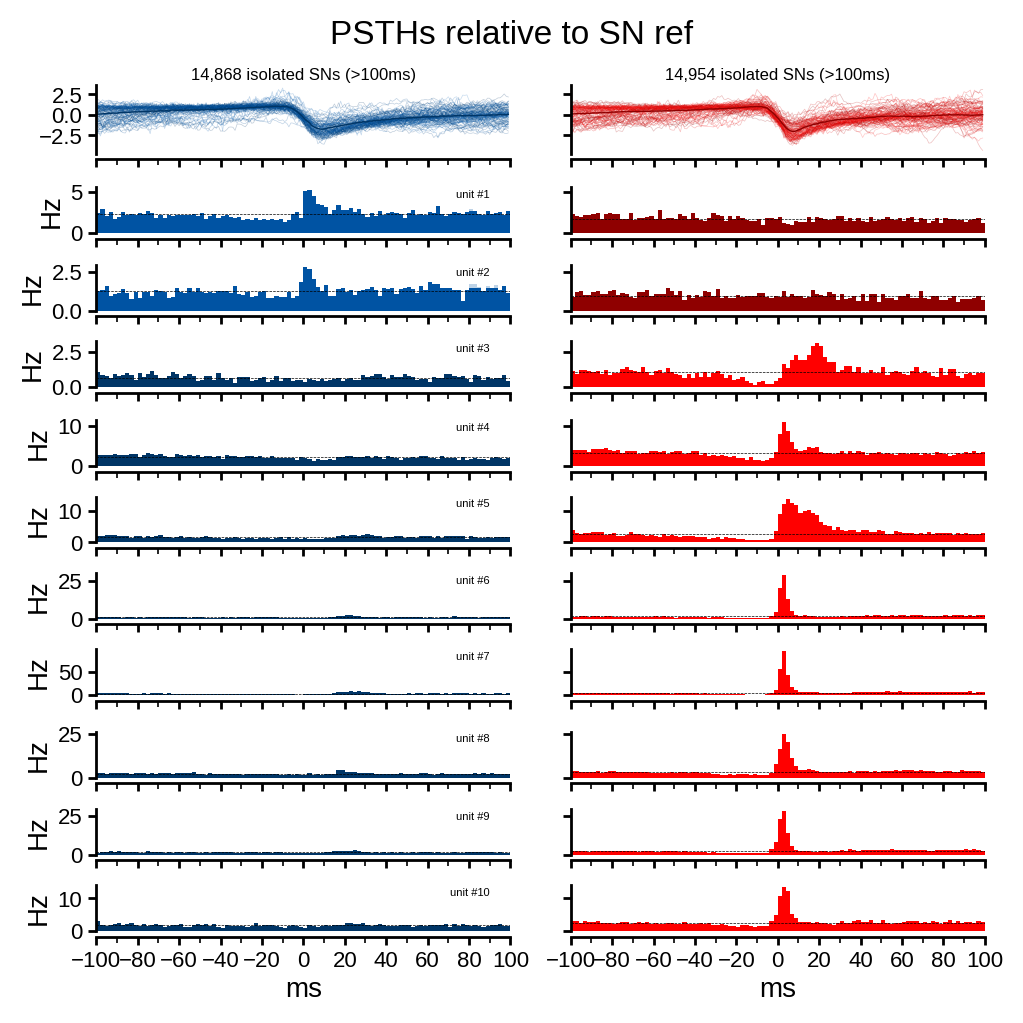

In [15]:
isolation = 100

isolated_sns = valid_sns.sel_mask(valid_sns.to_wins().interval_to_prev() > isolation)

psth_win = (-100, +100)

for align_to in [
    'ref',
]:

    sn_tested = [
        (f'isolated SNs (>{isolation}ms)', 'isolated_sns', isolated_sns, 2),
    ]

    for sn_desc, sn_label, sel_sns, tbin_size in pbar(sn_tested):

        psths_multichan = fig1.get_psths_multichan(spikes, sel_sns, psth_win=psth_win, align_to=align_to, tbin_size=tbin_size)

        example_traces = fig1.collect_example_traces(loader, sel_sns, align_to, psth_win)
        axs = fig1.plot_psths(spikes, sel_sns, psths_multichan, example_traces, sn_desc, suptitle=f'PSTHs relative to SN {align_to}', ylabel='Hz')

        axs.ravel()[0].figure.savefig(f'figs/{exp_name}_psths_{align_to}_{sn_label}.pdf')

## Another exp (EDF1 e)

In [16]:
exp_name = 'GL1003_20201102'

loader = reg.get_loader(exp_name)

In [17]:
spikes = trains.SpikeTrains.load_spikes_jrclust(
    reg.get_path(exp_name) / 'ironclust' / 'binaryTest_nxpoly2_64ch.csv',
    win_ms=Win(ms(hours=0), ms(hours=9))
)

spikes.cells.sort_index(inplace=True)
spikes.cells['side'] = 'left'

spikes.cells['side'] = spikes.cells['side'].map({
    reg.loc[exp_name, 'side0']: 0,
    reg.loc[exp_name, 'side1']: 1,
})

spikes

In [18]:
# note ironclust extracted only the first 9 hours!
valid_win = Win(ms(hours=2), ms(hours=9))

raw_all_sns = sne.SharpNegativeEvents(reg.load_all_sne(exp_name, suffix='_cdf'))
raw_all_sns = raw_all_sns.patch_simplified_channels()
raw_sns = raw_all_sns.sel_between(ref_time=valid_win)

valid_sns = raw_sns.sel_between(null_cdf=(-np.inf, .025))
valid_sns

start_time  start_idx  start_prominence  start_rel_height  \
event_id                                                                
143809    7.200256e+06       8189          2.871372          0.585967   
143812    7.200485e+06      15522          3.477659         -0.161474   
143818    7.200670e+06      21431          4.744055          0.214830   
143828    7.201235e+06      39506          8.412453          1.968282   
143843    7.201889e+06      60461          5.008412          0.100635   
...                ...        ...               ...               ...   
1970067   3.237503e+07  114401008          0.738184          0.061794   
1970222   3.237957e+07  114546184          4.758790         -0.068451   
1970468   3.238670e+07  114774381          4.217971         -0.281264   
1970763   3.239461e+07  115027557          3.932775         -0.278787   
1970764   3.239471e+07  115030802          3.967928         -0.171260   

              ref_time    ref_idx  ref_prominence  ref_rel_height  \
event_id                                                            
143809    7.200264e+06       8435       26.778331        9.828498   
143812    7.200491e+06      15717       28.083970        6.869125   
143818    7.200676e+06      21646       28.821974        3.956748   
143828    7.201240e+06      39695       69.971267       22.540052   
143843    7.201897e+06      60715       43.711335        7.668361   
...                ...        ...             ...             ...   
1970067   3.237503e+07  114401092        9.186743       -1.065092   
1970222   3.237958e+07  114546405       32.522233        6.876157   
1970468   3.238671e+07  114774607       28.482508        5.957000   
1970763   3.239462e+07  115027802       24.715413        4.591630   
1970764   3.239472e+07  115031024       29.920801        5.810761   

             stop_time   stop_idx  ...   acc_diff  amplitude_filt   amplitude  \
event_id                           ...                                          
143809    7.200273e+06       8735  ...   3.921955     -322.160556 -377.349854   
143812    7.200498e+06      15950  ...   3.734553     -246.793622 -304.107666   
143818    7.200681e+06      21801  ...   4.824802     -170.682284 -231.628418   
143828    7.201247e+06      39910  ...  12.057256     -608.878663 -735.015869   
143843    7.201900e+06      60792  ...   2.954296     -273.883044 -350.494385   
...                ...        ...  ...        ...             ...         ...   
1970067   3.237504e+07  114401277  ...   2.653017      -14.327204 -113.830566   
1970222   3.237958e+07  114546720  ...   4.789038     -295.257878 -378.112793   
1970468   3.238672e+07  114774927  ...   4.217971     -269.174111 -306.091309   
1970763   3.239463e+07  115028081  ...   3.932775     -215.033546 -253.601074   
1970764   3.239473e+07  115031245  ...   3.967928     -239.339178 -275.421143   

          duration      speed  amplitude_zscored  null_cdf  probe  channel  \
event_id                                                                     
143809    17.06250 -22.115742          -1.341691  0.007719      0        0   
143812    13.37500 -22.737022          -1.081274  0.013783      0        0   
143818    11.56250 -20.032728          -0.823570  0.016772      0        0   
143828    12.62500 -58.219079          -2.613396  0.000000      0        0   
143843    10.34375 -33.884654          -1.246205  0.002132      0        0   
...            ...        ...                ...       ...    ...      ...   
1970067    8.40625 -13.541183          -0.804638  0.019518      1        1   
1970222   16.75000 -22.573898          -2.672778  0.000000      1        1   
1970468   17.06250 -17.939417          -2.163677  0.000017      1        1   
1970763   16.37500 -15.487089          -1.792638  0.000201      1        1   
1970764   13.84375 -19.894981          -1.946878  0.000017      1        1   

          channel_true  
event_id                
143809              32  
143812              

In [19]:
spks = spikes.sel_isin()
ch_sns = valid_sns.sel(channel=1).sel_between(ref_time=valid_win)

classified_spikes = fig1.get_spikes_within_sn(ch_sns, spks)
counts = fig1.get_spike_count_per_sn(classified_spikes, ch_sns)


display(fig1.report_probs_table(counts))

prob no spike (%)  prob == 1 spike (%)  prob >= 1 spike (%)  \
1           98.549250             1.370781             1.450750   
2           98.420815             1.450750             1.579185   
3           97.901420             1.886945             2.098580   
4           98.833584             1.104218             1.166416   
5           96.160681             3.273882             3.839319   
6           98.776232             1.148645             1.223768   
7           98.579945             1.319084             1.420055   
8           98.000775             1.856250             1.999225   
9           97.113847             2.546083             2.886153   
10          98.239875             1.633306             1.760125   

    prob > 1 spike (%)  
1             0.079969  
2             0.128435  
3             0.211635  
4             0.062198  
5             0.565437  
6             0.075122  
7             0.100971  
8             0.142975  
9             0.340070  
10            0.126819

  0%|          | 0/2 [00:00<?, ?it/s]

load trace:   0%|          | 0/100 [00:00<?, ?it/s]

load trace:   0%|          | 0/100 [00:00<?, ?it/s]

load trace:   0%|          | 0/100 [00:00<?, ?it/s]

load trace:   0%|          | 0/100 [00:00<?, ?it/s]

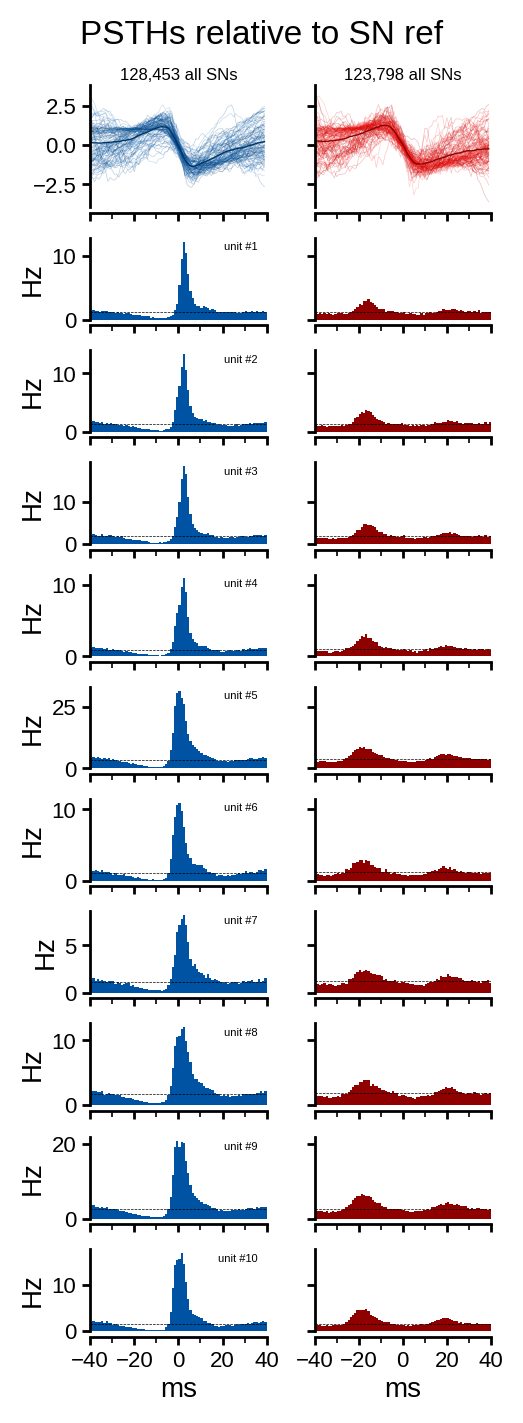

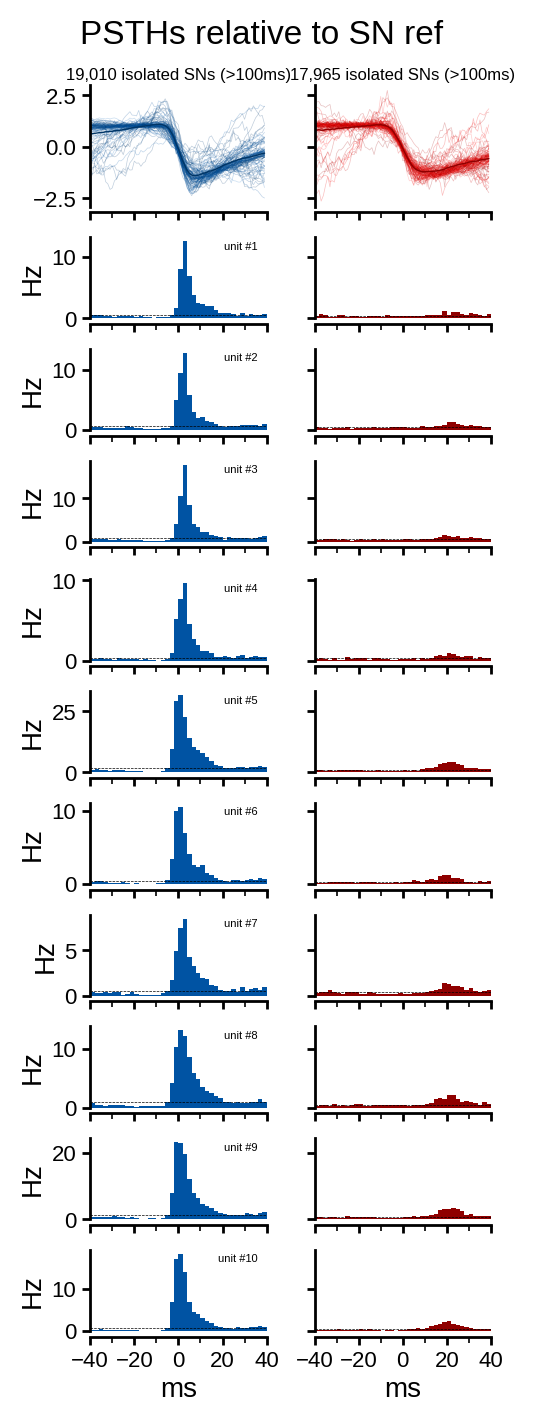

In [20]:
isolation = 100

isolated_sns = valid_sns.sel_mask(valid_sns.to_wins().interval_to_prev() > isolation)

psth_win = (-40, +40)

for align_to in [
    'ref',
]:

    sn_tested = [
        ('all SNs', 'all_sns',valid_sns, 1),
        (f'isolated SNs (>{isolation}ms)', 'isolated_sns', isolated_sns, 2),
    ]

    for sn_desc, sn_label, sel_sns, tbin_size in pbar(sn_tested):

        psths_multichan = fig1.get_psths_multichan(spikes, sel_sns, psth_win=psth_win, align_to=align_to, tbin_size=tbin_size)

        example_traces = fig1.collect_example_traces(loader, sel_sns, align_to, psth_win)
        axs = fig1.plot_psths(
            spikes, sel_sns, psths_multichan, example_traces, sn_desc, suptitle=f'PSTHs relative to SN {align_to}', ylabel='Hz',
            figsize=(2.5, 7),
        )

        axs.ravel()[0].figure.savefig(f'figs/{exp_name}_psths_{align_to}_{sn_label}.pdf')